# MobileNetV3-YOLOv3 for Text Detection

This notebook presents a text detection pipeline that integrates a `MobileNetV3_Small` backbone with the YOLOv3 architecture [\[1\]](https://arxiv.org/abs/1804.02767).<br>
The model is trained on the ICDAR 2015 dataset [\[2\]](https://www.kaggle.com/datasets/bestofbests9/icdar2015). Specifically, we cover:

- Data pipelining
- Model architecture
- Training loop
- Post-training optimization through one-shot pruning and quantization
- Inference

We will use YOLOv3 for a scene text detection task. The goal of scene text detection is to identify regions within images that contain text. These determined image-subspaces form an important basis for multimedia processing tasks and vision-related mobile applications [\[3\]](https://link.springer.com/content/pdf/10.1007/s11036-020-01650-z.pdf). The detection of text from a natural scene or an unpredictably structured image input like a smartphone camera can be challenging due to varying conditions of lighting, image depth, perspective, orientation, etc. A functioning text detection system for diverse environments can deliver a solid basis e.g. for live scene text translation, as complex images could be ``filtered'' through detection, selecting only the smaller, text-containing regions for the more extensive text recognition.

There exist many detection model paradigms like R-CNN [\[4\]](https://arxiv.org/abs/1506.01497) or Sliding window detectors [\[5\]](http://vision.stanford.edu/teaching/cs231b_spring1213/papers/CVPR05_DalalTriggs.pdf) which can take several forward passes to complete a detection cycle. The YOLO paradigm instead follows a more efficient one-stage detection approach, processing the entire image at once.

In [1]:
import gc
import csv
import math
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_optimizer as optim
import matplotlib.patches as patches
import torch.nn.utils.prune as prune
import torchvision.transforms.functional as TF

from PIL import Image
from pathlib import Path
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from mobileyolov3 import MobileYOLOv3, DSConv, Resizer

%matplotlib inline

---

## Hyperparameters

I *highly* recommend running this notebook on a GPU-enabled environment.

In [2]:
# CPU Seed for Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GPU Seed for Reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"Using training device: {device}")

batch_size = 128                # Amount of images to process at once per individual forward pass
num_workers = 4                 # Number of threads tasked with data loading
num_classes = 1                 # Number of classes to predict (only 1 for 'area with text')
learning_rate = 4e-4            # Really small learning rate to prevent training oscillations
num_epochs = 800                # Repeat training on the entire dataset this many times
lr_warmup = num_epochs * 0.1    # Increase learning rate at start of training, helps avoiding early convergence
weight_decay = 1e-4             # Slowly reduce weight values by this factor to better avoid biases
optim_k = 5                     # Average weight updates over optim_k steps to stabilize training
optim_alpha = 0.3               # Weight of influence of Lookahead's fast weights on the slow weights
prune_amount = 0.2              # Target percentage of weights to prune
dropout_rate = 0.4              # Brain damage rate to stabilize training
t_arch = str(device)            # Train your model to run on this architecture later on
anchors = [(0.28, 0.35), (0.43, 0.58), (0.62, 0.78)] # Pre-defined starter coords for bounding boxes, helps incentivize and guide training
num_anchors = len(anchors)

dataset_path = Path("./icdar2015/")
train_path = dataset_path / 'ch4_training_images'
train_labels = dataset_path / 'ch4_training_localization_transcription_gt'
test_path = dataset_path / 'ch4_test_images'
test_labels = dataset_path / 'ch4_test_localization_transcription_gt'

model_path = 'mobileyolov3_icdar2015.pth'

Using training device: cuda


---

## Datasets

I downloaded a copy of the [ICDAR 2015](https://www.kaggle.com/datasets/bestofbests9/icdar2015) dataset from Kaggle and placed it at `dataset_path`.<br>
The dataset is tiny at ~136.35 MB, but this suffices for training a small showcase text detection model.<br>
In practice, you should consider using larger and diverse datasets for better performance, like the [COCO-Text](https://bgshih.github.io/cocotext/) dataset.

Below is the [ICDAR 2015](https://www.kaggle.com/datasets/bestofbests9/icdar2015) dataset implementation which relies heavily on the parent `torch.utils.data.Dataset` class for efficient data loading.<br>
I decided to load the dataset at once during initialization to avoid any potential bottlenecks during training. This is feasible because the dataset is small.<br>
In practice, you should consider using a more efficient data loading strategy (loading by demand) for larger datasets.

To go a bit into detail, you will see that this dataset class doesn't just read and return some data. Instead, it transforms for an (image, label) pair both the image and the label in accordance with YOLO. The dataset provides images with a resolution of $1280\times 768$ pixels. YOLOv3 originally requests $416\times 416$ pixel images [\[1\]](https://arxiv.org/abs/1804.02767), but for the sake of downstream efficiency, I compress each image to $224\times 224$ pixels. Additionally, I try to make the most out of the little dataset we have by employing some data augmentation techniques like `ColorJitter`. Every time we pass over a certain image in training, it will get randomly tweaked and changed, reducing the risk for biases (somewhat, more could be done).

Interestingly, we also change the ground-truth box coordinates from the image-accompanying text files. Each image could contain some $n$ boxes, each written into the file in the $x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4$ format. YOLO does not like that and instead proposes boxes to be described by $x_{center}, y_{center}, width, height$. But that's just a first step and I'm not actually telling the full story.

Let's zoom out briefly. With YOLOv3, a given image is logically subdivided into static grid cells [\[1\]](https://arxiv.org/abs/1804.02767). Objects, meaning our regions containing text, will be detected through the grid cell overlaying the specific image region. And, coming back to the box coordinate format, the predictions made by the grid cell are made in the form of normalized coordinates ($x_{center}, y_{center}, width, height$ contains values of range $[0;1]$). Additionally, YOLOv3 will predict another $[0;1]$ range value called the objectness. The objectness scores associated with each grid-local decision are subsequently filtered for the highest ones, indicating some highest certainty for a predicted box containg text. Then, the bounding boxes with the greatest intersection over union (IoU) are iteratively suppressed by the current highest scoring bounding box estimation. 

For our data and model, we apply apply this logic for three different grid resolutions at once: $7\times 7$, $14\times 14$, and $28\times 28$.<br>
Now that's all fine and dandy, but we haven't talked about the `anchors` yet.<br>
The `anchors` are a set of (in our case hard-coded) predefined bounding boxes that are used as template/starter layouts for the bounding box sizes for objects in the image.
Put differently, instead of starting out predicting literally arbitrary bounding box dimensions from scratch, the network predicts modifications to these anchor boxes, which cuts down the initial learning curve and makes learning more efficient. Here, we use three different anchor box sizes for each grid resolution, resulting in a total of nine anchor boxes overlaying any one region of the image. We assign the normalized ground truth bounding boxes to the anchor box that has the highest IoU with the ground truth box. This is done for each grid resolution.

To summarize and to get back from the overall processing pipeline to looking at the dataset class, the dataset class is responsible for:

- Reading image and label files, images being off in size and labels being off in format
- Transforming the image to a $224\times 224$ pixel resolution and applying randomized augmentations to it, every time it is read
- Transforming the label boxes associated with that image from $n\times$ $x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4$ to $n\times$ $x_{center}, y_{center}, width, height$ format, where $x_{center}, y_{center}, width, height$ are normalized to $[0;1]$ and associated with the overlaying grid cell that is desired predict them in the end
- Assign an objectness score per box with the value of $1$, as we can be certain that the ground-truth boxes contain text
- Returning the transformed image and label for training
- Assigning best-matching anchor boxes to the ground-truth boxes for each grid resolution

In total, we compress the $n\times$ $x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4$ format to a data structure of shape $(grid_x, grid_y, num_{anchors} \times (x_{center 0;1}, y_{center 0;1}, width_{0;1}, height_{0;1},\ obj,\ cls))$ and we have three of these, i.e. the `coarse`, `medium`, and `fine` grid resolutions. Thus we can make $(7\times 7 \times 3) + (14\times 14 \times 3) + (28\times 28 \times 3) = 3087$ box predictions for each image, expressed through $18522$ individual values per prediction. That should be plenty enough to detect text in a scene.

In [5]:
class ICDAR2015(Dataset):
    """
    ICDAR2015 Dataset for YOLOv3 training.
    """
    def __init__(self, input_path, label_path, num_classes=1, num_anchors=3, img_size=(224, 224), img_format='.jpg', anchors=anchors):
        self.input_path = Path(input_path)  # Path to image files
        self.label_path = Path(label_path)  # Path to label files
        self.num_classes = num_classes      # Number of associable classes
        self.num_anchors = num_anchors      # Number of predictable distinct objects per grid tile
        self.img_size = img_size            # Image size
        self.batch_count = 0                # Batch counter
        self.anchors = anchors              # Anchor boxes (starter values)
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomAdjustSharpness(sharpness_factor=3.0, p=0.9),
            transforms.ToTensor()
        ])
        self.files = self._assemble_files(img_format=img_format)
        self.labels = [self._parse_label(label, Image.open(img).size) for img, label in self.files]

    def _assemble_files(self, img_format):
        image_files, data = list(self.input_path.glob(f'*{img_format}')), [] # List of image files + an empty data list
        for img_file in image_files:
            img_id = img_file.stem.split('_')[-1]
            label_file = self.label_path / f"gt_img_{img_id}.txt"
            if label_file.exists():
                data.append((img_file, label_file))
            else:
                print(f"Warning: No matching label file found for {img_file.name}")
        return data # list of (image, label_file) tuples, latter being a path to a .txt file

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path, _ = self.files[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        label = self.labels[idx]
        return img, label
    
    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self):
            raise StopIteration
        item = self[self.index]
        self.index += 1
        return item

    def _calculate_iou(self, box1, box2):
        # Intersection over Union (IoU) between two bounding boxes, range of returns is [0, 1]
        x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
        x2, y2 = min(box1[0] + box1[2], box2[0] + box2[2]), min(box1[1] + box1[3], box2[1] + box2[3])
        inter_area = max(0, x2 - x1) * max(0, y2 - y1)
        box1_area, box2_area = box1[2] * box1[3], box2[2] * box2[3]
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0 # Avoiding zero division

    def _to_grid(self, grid, box):
        # Convert bounding boxes to grid coordinates
        # BBox format: [x, y, w, h, obj, cls]
        # Anchor idxs == num_anchors: 0, 1, 2 
        # Assign BBox to the anchor (and its idx in grid coords therefore) with highest IoU
        grid_h, grid_w = grid.size(0), grid.size(1)
        x, y, w, h, obj, _ = box
        grid_x, grid_y = int(x * grid_w), int(y * grid_h)
        x, y = x * grid_w - grid_x, y * grid_h - grid_y
        best_iou, best_anchor_idx = 0, -1
        for anchor_idx, (anchor_w, anchor_h) in enumerate(self.anchors):
            anchor_box = torch.tensor([x, y, w / anchor_w, h / anchor_h])
            iou = self._calculate_iou(anchor_box.numpy(), [x, y, w, h])
            if iou > best_iou:
                best_iou = iou
                best_anchor_idx = anchor_idx
        if best_anchor_idx >= 0:
            anchor_slice = slice(best_anchor_idx * (5 + self.num_classes), (best_anchor_idx + 1) * (5 + self.num_classes))
            grid[grid_y, grid_x, anchor_slice][:4] = torch.tensor([x, y, w / self.anchors[best_anchor_idx][0], h / self.anchors[best_anchor_idx][1]])
            grid[grid_y, grid_x, anchor_slice][4] = obj

    def _parse_label(self, label_path, img_size):
        # Read Label data, parse it, apply it to (7, 14, 28) grid, resolutions,
        # Concatenate them, flatten and return them as a single tensor
        coarse_labels = torch.zeros((7, 7, self.num_anchors * (5 + self.num_classes)))
        medium_labels = torch.zeros((14, 14, self.num_anchors * (5 + self.num_classes)))
        fine_labels   = torch.zeros((28, 28, self.num_anchors * (5 + self.num_classes)))
        eps = 1e-3
        with open(label_path, 'r', encoding='utf-8-sig') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                row = torch.tensor([float(i) for i in row[:8]])
                x, y = (row[0::2].sum() / 4, row[1::2].sum() / 4)
                w = row[0::2].max() - row[0::2].min()
                h = row[1::2].max() - row[1::2].min()
                x, y = min(x, img_size[0] - eps), min(y, img_size[1] - eps)
                w, h = min(w, img_size[0] - eps), min(h, img_size[1] - eps)
                x, y = x / img_size[0], y / img_size[1]
                w, h = w / img_size[0], h / img_size[1]
                obj, cls = 1.0, 0.0
                box = torch.tensor([x, y, w, h, obj, cls])
                # Project bounding boxes onto grid layout resolutions
                self._to_grid(coarse_labels, box)
                self._to_grid(medium_labels, box)
                self._to_grid(fine_labels, box)
        return torch.cat([coarse_labels.flatten(), medium_labels.flatten(), fine_labels.flatten()], dim=0)

    def get_batch(self, batch_size, randomized=True):
        # returns pairs of (batch_size, 3, 224, 224) image with (batch_size, 18522) label
        # 18522 = (7*7*3*6) + (14*14*3*6) + (28*28*3*6)
        if randomized:
            indices = np.random.choice(len(self), batch_size, replace=False)
        else:
            indices = np.arange(self.batch_count, self.batch_count + batch_size) % len(self)
            self.batch_count += batch_size
        batch_images = torch.stack([self[i][0] for i in indices], dim=0)
        batch_labels = torch.stack([self[i][1] for i in indices], dim=0)
        return batch_images, batch_labels

    @staticmethod
    def collate_fn(batch):
        # collate_fn purpose is to convert list of (image, label) pairs into a single tensor
        # Gets used internally by DataLoader to prepare batches for training
        images, labels = zip(*batch)
        images = torch.stack(images, dim=0)
        labels = torch.stack(labels, dim=0)
        return images, labels

---

## Loss

Formulating the cost function turned out to be a major bottleneck for the training process.<br>
I set out to build the cost function by following a most bare YOLOv3 approach: The sum of the Mean Squared Error (MSE) between the predicted and ground-truth bounding boxes, 
incorporating the anchors by scaling the loss by the box area.<br>
I tweaked that with better IoU computation, scaling, focal loss and separated loss calculations.<br>

That didn't work, loads of re-tries ran into:
- `nan` losses during later training stages,
- sanity checks that claimed self-losses were >> 0,
- negative losses,
- losses that didn't even converge.

I found numerical stability to be one of many, but a really major issue.<br>
I suspect that the loss formulation was too sensitive to the model's output, which itself was not stable enough.<br>
Combine that with ill-scaled loss components and you get a misleading disaster of a loss function.

Now, let's go through the fixed `YoLoss` class. This class realizes a relatively custom loss function, specifically tailored for the scene text detection task.<br>
The loss function comprises these three distrinct components:

- Bounding box loss (`box_loss`): We measure how well the predicted bounding boxes align with the ground truth boxes. This is done through a combination of Complete IoU (CIoU) loss and smooth L1 loss. CIoU not only considers the overlap between boxes but also their aspect ratios and central point distances, providing a more comprehensive measure of similarity [\[6\]](https://arxiv.org/abs/1911.08287).
- Objectness loss (`obj_loss`): This evaluates how well the model predicts the presence or absence of an object (in our case, text) in each grid cell. We use focal loss for this component, which helps address class imbalance by down-weighting easy examples and focusing on hard ones [\[7\]](https://arxiv.org/abs/1708.02002). Different weights (`lambda_obj` and `lambda_noobj`) get applied for positive and negative samples to further try and balance the loss value calculation.
- Classification loss (`cls_loss`): Although less relevant for our distinctly binary classification task (i.e. text vs. no text), this loss is included for potential multi-class extensions. We use focal loss here as well [\[7\]](https://arxiv.org/abs/1708.02002), with a degree of label smoothing to help with generalization / against overfitting [\[8\]](https://arxiv.org/abs/2003.02819).

Calling `forward` ties everything together. First, the target tensor is reshaped (we get to why later, this is the model output's quirk) to match the three scale predictions of the YOLOv3-style formatted labels ($7\times 7$, $14\times 14$, and $28\times 28$ grids). Then it calculates the three wise loss components and combines them into a total loss, weighted again by respective `lambda` values.

It has to be noted that focal loss runs with a high weight (60.0) for positive/object-containing samples in the objectness prediction. This aims to significantly emphasize the sensitivity to detecting these text regions, which is crucial for our scene text detection task. Text regions might be rare, compared to the information contained by the overall grid-style prediction. Getting that little piece of text right is crucial for the model's performance. That's why a lot of weight is put on it. The loss function also includes the already mentioned safeguards against numerical instability, such as handling potential `NaN` values, which can occur during training due to the complexity of the loss calculation and the nature of the data. (We work with a lot of zeros and ones, which can lead to division by zero or multiplications with tiny values, making information even tinier (can't be processed meaningfully anymore) or blowing it up to infinity (underflow).)

Through balancing of the distinct loss components, we guide the network to simultaneously 
- improve its capability to locate text (`box_loss`), 
- identify the presence of text (`obj_loss`), and potentially 
- classify different types of text (`cls_loss`), all while handling potential challenges that might come from imbalanced low range of distribution data.

In [6]:
class YoLoss(nn.Module):
    """
    YOLOv3 Custom Loss Function.
    """
    def __init__(self, num_classes=num_classes, num_anchors=num_anchors, lambda_coord=1.0, lambda_obj=3.0, lambda_noobj=0.1,
                 lambda_class=2.0, iou_threshold=0.5, focal_alpha=0.5, focal_gamma=1.0, label_smoothing=0.1, anchors=anchors):
        super(YoLoss, self).__init__()
        self.num_classes = num_classes      # Amount of associable classes
        self.num_anchors = num_anchors      # Count of distinctly predictable objects per grid tile
        self.lambda_coord = lambda_coord    # BBox Coord Loss Weight
        self.lambda_obj = lambda_obj        # Objectness Loss Weight
        self.lambda_noobj = lambda_noobj    # Non-Objectness Loss Weight
        self.lambda_class = lambda_class    # Classification Loss Weight
        self.iou_threshold = iou_threshold  # Intersection over Union Threshold
        self.focal_alpha = focal_alpha      # Focal Loss weight of the positive class
        self.focal_gamma = focal_gamma      # Focal Loss weight of the negative class
        self.label_smoothing = label_smoothing  # Percentage of noise to add to the labels
        self.anchors = torch.tensor(anchors)    # Anchor boxes
        self.eps = 1e-7                     # Imprecision Avoidance Factor
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
    
    def focal_loss(self, pred, target):
        pred_prob = torch.sigmoid(pred)
        p_t = target * pred_prob + (1 - target) * (1 - pred_prob)
        alpha_factor = target * self.focal_alpha + (1 - target) * (1 - self.focal_alpha)
        modulating_factor = (1.0 - p_t).pow(self.focal_gamma)
        loss = self.bce_loss(pred, target)
        weight = torch.where(target == 1, torch.tensor(60.0).to(pred.device), torch.tensor(1.0).to(pred.device))
        return weight * (alpha_factor * modulating_factor * loss)

    def bbox_iou(self, box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
        if xywh:
            (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
            w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
            b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
            b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
        else:
            b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
            b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
            w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
            w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
        # Area of Bbox Intersection
        inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
                (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
        # Union Area
        union = (w1 * h1 + w2 * h2 - inter) + eps
        iou = inter / union
        if GIoU or DIoU or CIoU:
            cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)
            ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)
            if CIoU or DIoU:
                c2 = (cw ** 2 + ch ** 2) + eps
                rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4
                if DIoU:
                    return iou - rho2 / c2
                elif CIoU:
                    v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / (h2 + eps)) - torch.atan(w1 / (h1 + eps)), 2)
                    with torch.no_grad():
                        alpha = v / (v - iou + (1 + eps))
                    return iou - (rho2 / c2 + v * alpha)
            else:
                c_area = cw * ch + eps
                return iou - (c_area - union) / c_area
        else:
            return iou

    def get_box_loss(self, predictions, targets):
        box_loss = 0
        for pi, ti in zip(predictions, targets):
            mask = ti[..., 4] > 0
            p_boxes, t_boxes = pi[mask][..., :4], ti[mask][..., :4]
            if p_boxes.numel() > 0:
                iou = self.bbox_iou(p_boxes, t_boxes, CIoU=True)
                box_loss += torch.mean(1.0 - iou)
                box_loss += F.smooth_l1_loss(p_boxes, t_boxes, reduction='mean')
        return box_loss

    def get_obj_loss(self, predictions, targets):
        obj_loss = 0.0
        noobj_loss = 0.0
        for pi, ti in zip(predictions, targets):
            pred_obj = pi[..., 4]
            target_obj = ti[..., 4]
            obj_loss += torch.mean(self.focal_loss(pred_obj, target_obj))
            noobj_mask = target_obj == 0
            if noobj_mask.any():
                noobj_loss += torch.mean(self.bce_loss(pred_obj[noobj_mask], target_obj[noobj_mask]))
        return self.lambda_obj * obj_loss + self.lambda_noobj * noobj_loss

    def get_cls_loss(self, predictions, targets):
        cls_loss = 0
        if self.num_classes > 1:
            for pi, ti in zip(predictions, targets):
                pred_cls = pi[..., 5:]
                target_cls = ti[..., 5:]
                target_cls = (1 - self.label_smoothing) * target_cls + self.label_smoothing / self.num_classes
                cls_loss += torch.mean(self.focal_loss(pred_cls, target_cls))
        return cls_loss

    def forward(self, predictions, targets):
        b_size = targets.size(0) # Batch size can't be expected to be static
        coarse_size = 7 * 7 * self.num_anchors * (5 + self.num_classes)
        medium_size = 14 * 14 * self.num_anchors * (5 + self.num_classes)
        fine_size = 28 * 28 * self.num_anchors * (5 + self.num_classes)

        flat_coarse, flat_medium, flat_fine = torch.split(targets, [coarse_size, medium_size, fine_size], dim=1)
        t_coarse = flat_coarse.view(b_size, 7, 7, self.num_anchors, (5 + self.num_classes))
        t_medium = flat_medium.view(b_size, 14, 14, self.num_anchors, (5 + self.num_classes))
        t_fine = flat_fine.view(b_size, 28, 28, self.num_anchors, (5 + self.num_classes))

        targets_split = [t_coarse, t_medium, t_fine]
        
        box_loss = self.get_box_loss(predictions, targets_split)
        obj_loss = self.get_obj_loss(predictions, targets_split)
        cls_loss = self.get_cls_loss(predictions, targets_split)
                
        total_loss = self.lambda_coord * box_loss * obj_loss + self.lambda_class * cls_loss

        if torch.isnan(total_loss):
            # Debugging purposes (I saw all of these go NaN at some point, fun times)
            print(f'box_loss={box_loss}, obj_loss={obj_loss}, cls_loss={cls_loss}')
            total_loss = torch.where(torch.isnan(total_loss), torch.zeros_like(total_loss), total_loss)

        return total_loss

---

### Data + Loss Sanity Check

The loss function is custom and turned out maybe a bit complex.<br>
We have to carefully sanity check both the data pipeline and the loss function behavior to make sure correct data is evaluated correctly with consistency.

We can expect some certain behavior from the dataset class:
- the dataset should return a tuple `image` and `label`, no matter if we want one sample or a batch
- a single image should be a tensor of shape `(batch_size, 3, H, W)`
- a single label should be a tensor of shape `(batch_size, (7*7*3*6) + (14*14*3*6) + (28*28*3*6))`

Crucially, we can also set some expectations to our loss function's behavior:
- loss goes towards `0`, we should expect just very slight deviation e.g. due to label smoothing
- loss does not scale with the number of boxes, as the loss is roughly normalized by the number of boxes
- loss does not scale with the image size, as the image size is normalized
- loss does not scale with the batch size, as the loss is normalized by the batch size

I wrote a simple sanity check to verify these expectations.<br>
According to the expectations, given an image and a label tensor, we show the image and and project the label's boxes onto it.<br>
If that looks good on random examples, we can be confident that the data pipeline and loss function are working as expected.

Also, using `get_loss` function, we can simulate the loss calculation using dataset label pairs.<br>
What I mean by that is that comparing the label against itself simulates ideal prediction.<br>
Equally, comparing the label against a random other label simulates false model behavior.

In [7]:
train_dataset = ICDAR2015(train_path, train_labels, num_classes)
sanity_criterion = YoLoss()

Image Batch: torch.Size([5, 3, 224, 224]) 	Label: torch.Size([5, 18522])
Image: torch.Size([3, 224, 224]) 	Label: torch.Size([18522])


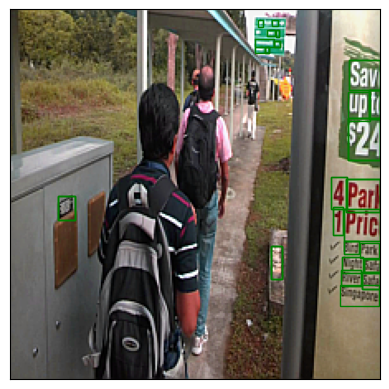

Self Loss: tensor(0.0005) 
 --------------------------------------------------
Random Comparison tensor(19.0449) 
 --------------------------------------------------


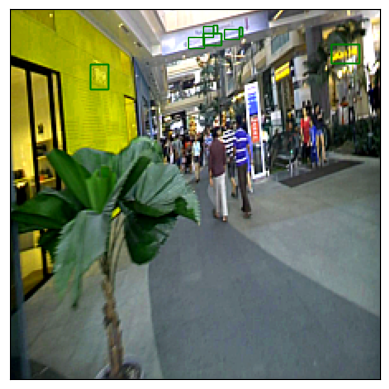

Self Loss: tensor(0.0005) 
 --------------------------------------------------
Random Comparison tensor(18.6952) 
 --------------------------------------------------


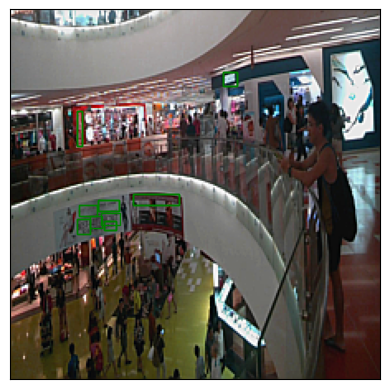

Self Loss: tensor(0.0002) 
 --------------------------------------------------
Random Comparison tensor(18.7174) 
 --------------------------------------------------


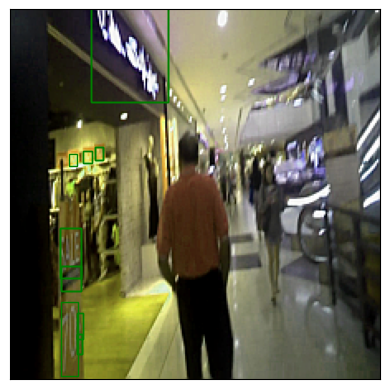

Self Loss: tensor(0.0002) 
 --------------------------------------------------
Random Comparison tensor(18.8213) 
 --------------------------------------------------


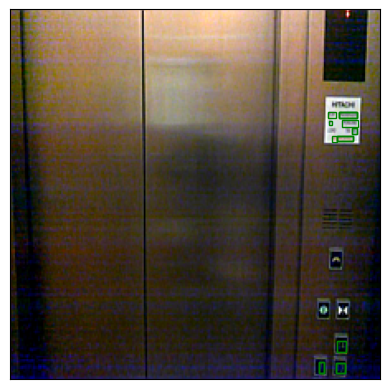

Self Loss: tensor(0.0007) 
 --------------------------------------------------
Random Comparison tensor(18.6681) 
 --------------------------------------------------


In [8]:
sanity_batch = 5
imgb, labelb = train_dataset.get_batch(sanity_batch)

print('Image Batch:', imgb.shape, '\tLabel:', labelb.shape)
print('Image:', imgb[0].shape, '\tLabel:', labelb[0].shape)

def get_loss(label_a, label_b, title='', grid_sizes=[(7, 7), (14, 14), (28, 28)]):
    coarse_size = grid_sizes[0][0] * grid_sizes[0][1] * num_anchors * (5 + num_classes)
    medium_size = grid_sizes[1][0] * grid_sizes[1][1] * num_anchors * (5 + num_classes)
    fine_size = grid_sizes[2][0] * grid_sizes[2][1] * num_anchors * (5 + num_classes)
    coarse_flat, medium_flat, fine_flat = torch.split(label_a, [coarse_size, medium_size, fine_size], dim=0)
    coarse = coarse_flat.view(grid_sizes[0][0], grid_sizes[0][1], num_anchors, (5 + num_classes))
    medium = medium_flat.view(grid_sizes[1][0], grid_sizes[1][1], num_anchors, (5 + num_classes))
    fine = fine_flat.view(grid_sizes[2][0], grid_sizes[2][1], num_anchors, (5 + num_classes))
    predictions = [coarse.unsqueeze(0), medium.unsqueeze(0), fine.unsqueeze(0)]
    print(title, sanity_criterion(predictions, label_b.unsqueeze(0)), '\n', '-' * 50)

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area, box2_area = box1[2] * box1[3], box2[2] * box2[3]
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def show_image_with_bboxes(img, label, num_anchors=3, num_classes=1, grid_sizes=[(7, 7), (14, 14), (28, 28)], anchors=anchors):
    img_np = TF.to_pil_image(img)
    _, ax = plt.subplots(1)
    ax.imshow(img_np)
    ax.set_xticks([])
    ax.set_yticks([])
    coarse_size = grid_sizes[0][0] * grid_sizes[0][1] * num_anchors * (5 + num_classes)
    medium_size = grid_sizes[1][0] * grid_sizes[1][1] * num_anchors * (5 + num_classes)
    fine_size = grid_sizes[2][0] * grid_sizes[2][1] * num_anchors * (5 + num_classes)
    coarse_flat, medium_flat, fine_flat = torch.split(label, [coarse_size, medium_size, fine_size], dim=0)
    coarse = coarse_flat.view(grid_sizes[0][0], grid_sizes[0][1], num_anchors, (5 + num_classes))
    medium = medium_flat.view(grid_sizes[1][0], grid_sizes[1][1], num_anchors, (5 + num_classes))
    fine = fine_flat.view(grid_sizes[2][0], grid_sizes[2][1], num_anchors, (5 + num_classes))
    def draw_boxes(grid, grid_w, grid_h, anchors):
        for y in range(grid_h):
            for x in range(grid_w):
                best_iou, best_anchor_idx = 0, -1
                for a in range(num_anchors):
                    box = grid[y, x, a]
                    if box[4] > 0:
                        anchor_w, anchor_h = anchors[a]
                        w = box[2].item() * anchor_w * img_np.width
                        h = box[3].item() * anchor_h * img_np.height
                        cx = (box[0].item() + x) / grid_w * img_np.width
                        cy = (box[1].item() + y) / grid_h * img_np.height
                        normalized_box = torch.tensor([cx - w / 2, cy - h / 2, w, h])
                        iou = calculate_iou(normalized_box.numpy(), [cx - w / 2, cy - h / 2, w, h])
                        if iou > best_iou:
                            best_iou = iou
                            best_anchor_idx = a
                if best_anchor_idx != -1:
                    best_box = grid[y, x, best_anchor_idx]
                    anchor_w, anchor_h = anchors[best_anchor_idx]
                    w_best = best_box[2].item() * anchor_w * img_np.width
                    h_best = best_box[3].item() * anchor_h * img_np.height
                    cx_best = (best_box[0].item() + x) / grid_w * img_np.width
                    cy_best = (best_box[1].item() + y) / grid_h * img_np.height
                    rect = patches.Rectangle((cx_best - w_best / 2, cy_best - h_best / 2), w_best, h_best,
                                             linewidth=1, edgecolor='g', facecolor='none')
                    ax.add_patch(rect)
    draw_boxes(coarse, grid_sizes[0][0], grid_sizes[0][1], anchors)
    draw_boxes(medium, grid_sizes[1][0], grid_sizes[1][1], anchors)
    draw_boxes(fine, grid_sizes[2][0], grid_sizes[2][1], anchors)
    plt.show()

for i in range(imgb.shape[0]):
    show_image_with_bboxes(imgb[i], labelb[i])
    get_loss(labelb[i], labelb[i], title='Self Loss:')
    another_idx = random.choice([num for num in range(sanity_batch) if num != i])
    get_loss(labelb[i], labelb[another_idx], title='Random Comparison')

---

## Selecting Activation Functions

At this point, we can use a good data pipeline and a working loss function.<br>
I now, for a short intermission, defined and just visualized several activation functions, akin to the works of [\[9\]](https://arxiv.org/abs/1710.05941), including **ReLU, Leaky ReLU, Sigmoid, ELU, Softplus, and a Swish derivative**.<br>
Visualizing them all together allows for a clear comparison of their behavior. This will come in handy later.<br>

For now, different activation functions project into differently shaped spaces, which can affect the model's ability to learn and generalize.<br>
For example, if you want to predict a binary output, you might want to use a Sigmoid activation function in the final layer.<br>
Using a *ReLU* activation function in the final layer might not be the best choice, as it can output negative values.

The choice of activation function therefore closely depends on the task at hand and the desired output shapes and scales.

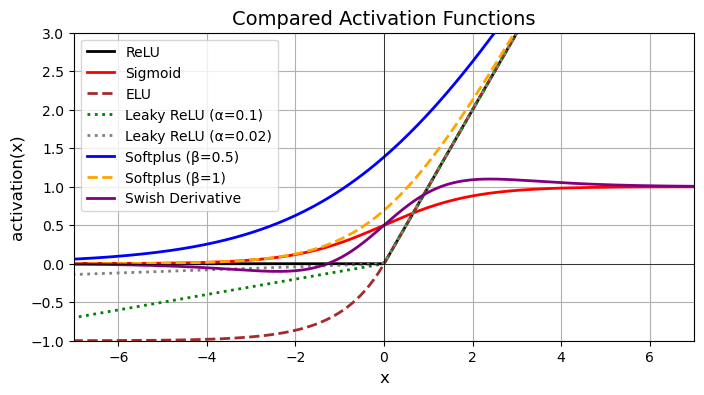

In [2]:
# This is interesting too: https://pat.chormai.org/blog/2020-relu-softplus (considered, but didn't end up using it)
# For Swish: https://arxiv.org/pdf/1710.05941.pdf (esp pp. 5-6) (considered, but didn't end up using it)

x = np.linspace(-10, 10, 400)
y_relu = np.maximum(0, x)
y_leaky_relu_0_1 = np.where(x > 0, x, 0.1 * x)
y_leaky_relu_0_02 = np.where(x > 0, x, 0.02 * x)
y_sigmoid = 1 / (1 + np.exp(-x))
y_softplus_beta_0_5 = (1 / 0.5) * np.log(1 + np.exp(0.5 * x))
y_softplus_beta_1 = (1 / 1) * np.log(1 + np.exp(1 * x))
y_swish_derivative = (x * y_sigmoid) + y_sigmoid * (1 - (x * y_sigmoid))
y_elu = np.where(x > 0, x, np.exp(x) - 1)

plt.figure(figsize=(8, 4))
plt.plot(x, y_relu, label="ReLU", linewidth=2, color='black')
plt.plot(x, y_sigmoid, label="Sigmoid", linewidth=2, color='red')
plt.plot(x, y_elu, label="ELU", linewidth=2, linestyle='dashed', color='brown')
plt.plot(x, y_leaky_relu_0_1, label="Leaky ReLU (α=0.1)", linewidth=2, linestyle='dotted', color='green')
plt.plot(x, y_leaky_relu_0_02, label="Leaky ReLU (α=0.02)", linewidth=2, linestyle='dotted', color='gray')
plt.plot(x, y_softplus_beta_0_5, label="Softplus (β=0.5)", linewidth=2, color='blue')
plt.plot(x, y_softplus_beta_1, label="Softplus (β=1)", linewidth=2, linestyle='dashed', color='orange')
plt.plot(x, y_swish_derivative, label="Swish Derivative", linewidth=2, color='purple')

plt.title('Compared Activation Functions', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('activation(x)', fontsize=12)
plt.legend(loc='upper left')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlim(-7, 7)
plt.ylim(-1, 3)

plt.show()

---

# Model

Originally I implemented the model here too, but I extracted it for ease of readability and reusability. See `mobileyolov3.py`.<br>
Before going into detail, we use `MobileNetV3` for `YOLOv3` as a foundation because it is well-established, well documented and allows to focus on downstream pipeline optimization. 

Let's get into the model: The `MobileYOLOv3` class implements a version of YOLOv3 that is mobile-optimized for the scene text detection task.<br>
The architecture comprises three main components:

- Backbone: We utilize `MobileNetV3-Small` as our main feature extractor [\[10\]](https://arxiv.org/abs/1905.02244). This pre-trained network, loaded with weights from a training run on the ImageNet dataset, provides a foundation for feature extraction while focusing on maintaining computational efficiency.
- Custom layers: Several custom layers to enhance the model's performance while still keeping efficiency in mind. These include:
    - `ECA` - Efficient Channel Attention, which allows to learnably focus on the information from certain image areas or contents efficiently [\[11\]](https://openaccess.thecvf.com/content_CVPR_2020/papers/Wang_ECA-Net_Efficient_Channel_Attention_for_Deep_Convolutional_Neural_Networks_CVPR_2020_paper.pdf).
    -`DSConv` - Depthwise Separable Convolution, the more compute-efficient version of a Conv2d, for the key insight that separating depth- and point-wise convolutions makes compute quicker [\[12\]](https://arxiv.org/abs/1610.02357).
    - `Resizer` helps with Skip Connections - Put in a tensor of some size, and it will scale that tensor up or down as needed.

Looping back to what we did during the dataset preparation and according to YOLOv3's design, we implement the three detection heads for multi-scale prediction:

- Coarse ($7\times 7$ grid): Ideally Detects larger text regions.
- Medium ($14\times 14$ grid): Hopefully Captures medium-sized text.
- Fine ($28\times 28$ grid): Aims to identify smaller text instances.

The two larger detection heads utilize skip connections from earlier layers within the MobileNetV3 backbone, allowing the model to leverage both low-level and high-level features for prediction. That's what I'd say in hindsight, but in reality, I integrated skip-connections just to optimize gradient flow during early implementation stages where I had to witness frantic training behavior. But the former argument sounds way more sophisticated lol.

The `_activate` method applies appropriate activation functions to the raw predictions:
- Sigmoid for x, y coordinates and objectness scores, constraining them to [0, 1].
- Sigmoid with anchor box scaling for width and height predictions.
- Sigmoid for class probabilities (although less relevant for our binary classification task).

Very sophisticated indeed (not), especially when considering that we took an extra intermission to visualize activation functions. Couldn't we have found a better activation function for the task? Turns out, Sigmoid is a good choice for the task at hand, because it constrains the output to a range of $[0;1]$, which is exactly what we need for the bounding box coordinates and objectness scores, and it does so in a smooth and differentiable and fast manner. Anyway, we know the behavior is good, as we've seen that in our visualization too.

I should add that we use `dropout` layers before each detection head [\[13\]](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf). Think of dropout layers as rotating sprinklers, distributing the gradient/learning information only to some subset of the actual weights, thereby over time distributing the learning efforts across the entire model more evenly. This helps prevent overfitting, which is crucial given our *really* limited dataset size. The model's output consists of three tensors, one for each detection scale, each of the general shape `(batch_size, grid_size, grid_size, num_anchors, 5 + num_classes)`. This format aligns with our custom loss function, but returning three tensors will be messy for the GPU to handle. Instead, the three tensors are flattened and concatenated to one big tensor of size `(batch_size, 18522)`. That's why in the loss class, we need to reconstruct the three scales from the one big tensor. It's a bit of a hassle, but it's worth it for the sake of the GPU speed.


---

## Training

Now for the training run: The training and test datasets are initialized to use our custom `collate_fn` loading function to supply data batches.<br>
We randomly shuffle our training set and use something called *pinned memory*.<br>
The advantage of `pin_memory=True` is that data is transfered to the training device via page-locked memory (the data we want to use on the device is loaded to and kept only in RAM).<br>
This is good both for GPUs and (in a limited fashion also) good for CPUs, but it requires sufficient amounts of [RAM](https://www.youtube.com/watch?v=SoCF1IljMkU) to be available.

<center><img src="https://pytorch.org/tutorials/_images/pinmem.png" alt="why pin_memory" width="400" height="auto"></center>

In [9]:
train_dataset = ICDAR2015(train_path, train_labels, num_classes)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                           num_workers=num_workers, collate_fn=ICDAR2015.collate_fn,
                           pin_memory=True)

val_dataset = ICDAR2015(test_path, test_labels, num_classes)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=num_workers, collate_fn=ICDAR2015.collate_fn,
                         pin_memory=True)

We use `evaluate` to manage model predictions on the test set during training. This will produce the validation loss, which itself will indicate if we generalize and actually learn something and continue to do so on data we don't actually train with or process at all.<br>

With all the above done, still, early training runs often struggled with overfitting.

A measure I found to actually be most helpful turned out to be the slightly counter-intuitive `mixup_data` [\[14\]](https://openreview.net/forum?id=r1Ddp1-Rb).<br>
In short, for a subset of the current training batch, we intentionally mix up their labels.<br>
This way we (kind of forcefully) counter possibilities for overfitting on the training data.<br>
While I was initially skeptical, I observed a noticeable improvement in the stability of validation loss reduction without adversely affecting performance on the training set after all.

In [10]:
def evaluate(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=str(device)):
                outputs = model(images)
                loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def mixup_data(x, y, alpha=0.1):
    # Intentionally mess up image-to-label relationship for alpha percentage of batch entries
    # Helps to avoid overfitting (when not overdone)
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    else:
        return x, y, y, 1

To preserve the already contained information regarding image content embedded in the `MobileNetV3` backbone weights, the influence of our training on the backbone during our training loop gets minimized a bit.

Static Learning Rates, if too small, could expose training to the risk of the model getting stuck in local minima, thus converging early. On the other hand, choosing too large of a learning rate might get training to overshoot the local optimium. To prevent both scenarios, I chose to use a `OneCycleLR` which scales the learning rate up, then down again across all of training [\[15\]](https://arxiv.org/abs/1708.07120).

I also utilized a technique called `Lookahead`, which enhances the optimization process during training, rather than using e.g. more constraining batch augmentation.<br>
This wrapper around our AdamW optimizer manages two sets of model weights: A slow and a fast set [\[16\]](https://arxiv.org/abs/1907.08610).<br>
The fast set is updated step-wise, the slow set is updated with an average across `optim_k` fast weights.<br>
This helps avoiding some step-wise oscillations and calms optimization somewhat down.<br>

Training also becomes more robust against extreme individual training examples.<br>
Pair that with the employed gradient clipping and we have a training loop that is more stable and less prone to diverging/oszillating too harshly.

In [11]:
model = MobileYOLOv3(num_classes=num_classes, dropout_rate=dropout_rate, anchors=torch.tensor(anchors, dtype=torch.float32, device=device)).to(device)
criterion = YoLoss()

# Adam with decoupled weight decay from gradient update
base_optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': learning_rate * 0.8, 'weight_decay': weight_decay * 0.6},
    {'params': model.conv_7.parameters()},
    {'params': model.eca_7.parameters()},
    {'params': model.det1.parameters()},
    {'params': model.r_1024_128.parameters()},
    {'params': model.r_48_128.parameters()},
    {'params': model.conv_14.parameters()},
    {'params': model.eca_14.parameters()},
    {'params': model.det2.parameters()},
    {'params': model.r_512_64.parameters()},
    {'params': model.r_24_64.parameters()},
    {'params': model.conv_28.parameters()},
    {'params': model.eca_28.parameters()},
    {'params': model.det3.parameters()},
], lr=learning_rate, weight_decay=weight_decay)

# Switching between providing 'fast weights' and 'slow weights' for AdamW optimizer update calculations
optimizer = optim.Lookahead(base_optimizer, k=optim_k, alpha=optim_alpha)

# Gradually warm and then cool down LR over time
scheduler = OneCycleLR(optimizer, max_lr=learning_rate*2, epochs=num_epochs, steps_per_epoch=len(train_loader),
                       pct_start=0.3, anneal_strategy='cos', div_factor=10.0, final_div_factor=10000.0)

# Helps avoiding numerical underflow/overflow through assigning mixed-precision by necessity rather than default
scaler = torch.amp.GradScaler(enabled=(str(device) != 'cpu'))

In [12]:
# 800 epochs, ~200 Minutes on 1x3060

lossi, losst = [], []
lowsi = float('inf')

# Portraying the fine selection of hyperparameters
print(f'Batch Size:\t {batch_size}\n',
      f'Learning Rate:\t {learning_rate}\n',
      f'Weight Decay:\t {weight_decay}\n',
      f'Num Epochs:\t {num_epochs}\n',
      f'LR Warmup:\t {lr_warmup}\n',
      f'Optim K:\t {optim_k}\n',
      f'Optim Alpha:\t {optim_alpha}\n',
      f'Prune Amount:\t {prune_amount}\n',
      f'Target Architecture:\t {t_arch}\n',
      f'Num Anchors:\t {num_anchors}\n',
      f'Dropout Rate:\t {dropout_rate}\n\n')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for files, targets in train_loader:
        files = files.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        mixed_files, targets_a, targets_b, lam = mixup_data(files, targets)
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type=str(device)):
            logits = model(mixed_files)
            loss_a = criterion(logits, targets_a)
            loss_b = criterion(logits, targets_b)
            loss = lam * loss_a + (1 - lam) * loss_b # Mixup Loss Calculation

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        
    epoch_loss /= len(train_loader)
    lossi.append(epoch_loss)
    t_loss = evaluate(model, criterion, val_loader, device)
    losst.append(t_loss)
    gc.collect()
    torch.cuda.empty_cache()
    print(f'Epoch [{epoch+1:3}/{num_epochs}] | Train: {epoch_loss:8.6f} | Test: {t_loss:8.6f} | LR: {optimizer.param_groups[-1]["lr"]:.6f}')

Batch Size:	 128
 Learning Rate:	 0.0004
 Weight Decay:	 0.0001
 Num Epochs:	 800
 LR Warmup:	 80.0
 Optim K:	 5
 Optim Alpha:	 0.3
 Warmup Start:	 0.35
 Scheduler T0:	 80.0
 Scheduler Tmult:	 2
 Prune Amount:	 0.2
 Target Architecture:	 cuda
 Num Anchors:	 3
 Dropout Rate:	 0.4


Epoch [  1/800] | Train: 15.553848 | Test: 14.639543 | LR: 0.000080
Epoch [  2/800] | Train: 14.907664 | Test: 14.454878 | LR: 0.000080
Epoch [  3/800] | Train: 14.578331 | Test: 13.724379 | LR: 0.000080
Epoch [  4/800] | Train: 14.177286 | Test: 13.589228 | LR: 0.000080
Epoch [  5/800] | Train: 13.868238 | Test: 13.016906 | LR: 0.000081
Epoch [  6/800] | Train: 13.607736 | Test: 12.919088 | LR: 0.000081
Epoch [  7/800] | Train: 13.295711 | Test: 12.844635 | LR: 0.000082
Epoch [  8/800] | Train: 13.138729 | Test: 12.394155 | LR: 0.000082
Epoch [  9/800] | Train: 12.877526 | Test: 12.338135 | LR: 0.000082
Epoch [ 10/800] | Train: 12.707392 | Test: 11.978590 | LR: 0.000083
Epoch [ 11/800] | Train: 12.534091 | T

In [13]:
# Saving the unaltered model
torch.save(model.state_dict(), f'solid_{model_path}')

---

## Loss Graph

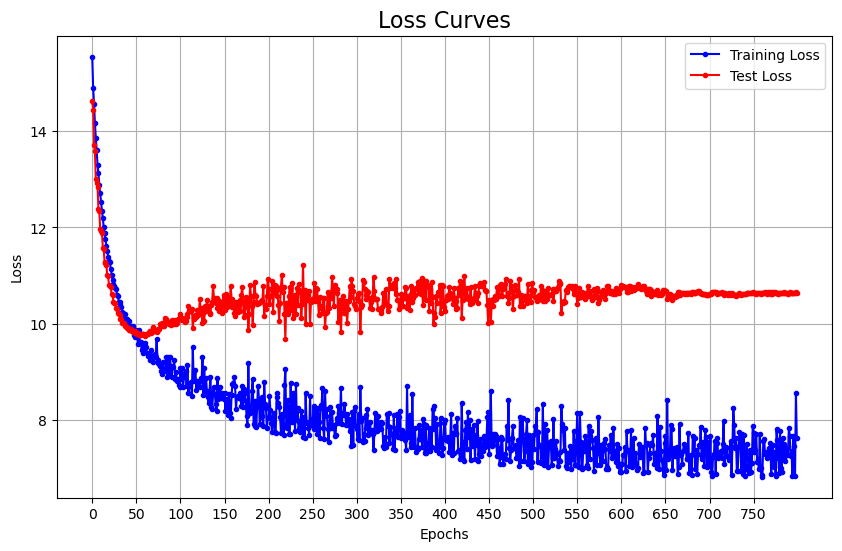

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lossi, label="Training Loss", color='blue', marker='o', linestyle='-', markersize=3)
plt.plot(range(num_epochs), losst, label="Test Loss", color="red", marker='o', linestyle='-', markersize=3)

plt.title('Loss Curves', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(0, num_epochs, 50))
plt.legend(loc='upper right')
plt.show();

We nicely converge on the training set, and we do not see any increase in loss for the test set during the later training stages.

This implies we learned, we could apply training data information to test data, but we consistently didn't reach as good results on the test data.<br>
I attribute that to the dataset size and thus a necessarily present lack of richness in example variety.

Consequently, I interpret the **loss curves to show no signs of overfitting or underfitting**, suggesting that we should consider increasing the dataset size, switching out the dataset for a larger one or implementing additional data augmentation measures.

---

## Pruning & Quantization

Pruning and quantization get applied after model training has finished.

**Pruning** picks out tiny/non-contributing weights and marks them in a pruning mask, which we then can use to remove marked weights from the model structure all together [\[17\]](https://arxiv.org/abs/2011.00241).<br>
This frees up memory and reduces resource demands. Impact on accuracy varies per use-case though. Playing with that too much wasn't really my objective, so I chose a lower pruning rate to be safe. Feel free to experiment here.

**Quantization** is an additional step that, considering weights, doesn't look at the weight values themselves, but the difference between required and actually granted numeric precision [\[18\]](https://arxiv.org/abs/1510.00149).<br>
If a weight can be represented little informational loss through a coarser numeric precision, this could decrease memory and computation demands.

In [ ]:
def prune_model(model, amount):
    def prune_conv(conv, amount):
        prune.ln_structured(conv, name='weight', amount=amount, n=2, dim=0)

    for _, module in model.named_modules():
        if isinstance(module, DSConv):
            prune_conv(module.depthwise, amount)
            prune_conv(module.pointwise, amount)
        elif isinstance(module, Resizer):
            if isinstance(module.conv, DSConv):
                prune_conv(module.conv.depthwise, amount)
                prune_conv(module.conv.pointwise, amount)
            else:
                prune_conv(module.conv, amount)
        elif isinstance(module, nn.Conv2d):
            prune_conv(module, amount)

    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            parameters_to_prune.append((module, 'weight'))
        elif isinstance(module, DSConv):
            parameters_to_prune.extend([(module.depthwise, 'weight'), (module.pointwise, 'weight')])
        elif isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)
    return model

def quantize_model(model, device):
    """
    Crunch numeric precision of weights and activations.
    """
    model = model.cpu() # Works only on CPU
    quantized_model = torch.quantization.quantize_dynamic(model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8, inplace=True) # inplace=True avoids deepcopy issues
    return quantized_model.to(device)

def lift_prune_mask(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight_mask'):
                module.weight.data *= module.weight_mask
                prune.remove(module, 'weight')
            elif hasattr(module, 'weight_orig'):
                # If there's a weight_orig but no mask, it means pruning was applied but the mask was removed
                module.weight.data = module.weight_orig.data
                delattr(module, 'weight_orig')
        elif isinstance(module, DSConv):
            for conv in [module.depthwise, module.pointwise]:
                if hasattr(conv, 'weight_mask'):
                    conv.weight.data *= conv.weight_mask
                    prune.remove(conv, 'weight')
                elif hasattr(conv, 'weight_orig'):
                    conv.weight.data = conv.weight_orig.data
                    delattr(conv, 'weight_orig')
        elif isinstance(module, Resizer):
            if isinstance(module.conv, DSConv):
                for conv in [module.conv.depthwise, module.conv.pointwise]:
                    if hasattr(conv, 'weight_mask'):
                        conv.weight.data *= conv.weight_mask
                        prune.remove(conv, 'weight')
                    elif hasattr(conv, 'weight_orig'):
                        conv.weight.data = conv.weight_orig.data
                        delattr(conv, 'weight_orig')
            else:
                if hasattr(module.conv, 'weight_mask'):
                    module.conv.weight.data *= module.conv.weight_mask
                    prune.remove(module.conv, 'weight')
                elif hasattr(module.conv, 'weight_orig'):
                    module.conv.weight.data = module.conv.weight_orig.data
                    delattr(module.conv, 'weight_orig')
    return model

In [ ]:
# Prune, Quantize
pruned_model = prune_model(model, amount=prune_amount)
lifted_model = lift_prune_mask(pruned_model)
quantized_model = quantize_model(lifted_model, device)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_path)

---

## Inference

I kept this short and sweet. We load the model, set it to `eval()` mode and run some inference on it.<br>
I show examples from the training set here, frankly because I want to prove that learning has actually occured and text was learnt to be identified by the model.
I'm quite happy with the result, as we built a model for text detection which is now only ~7.4 MB in size.

Being this small, our model can easily be run on smartphones or on edge-devices.

In [15]:
def load_model(model_class, num_classes, model_path, device='cpu'):
    """
    Load a PyTorch model for inference on the target device, regardless of where it was originally trained.
    """
    if isinstance(device, str):
        device = torch.device(device)

    # Load to CPU first
    state_dict = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    # Remove 'module.' prefix caused by SWA
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Remove pruning-related keys
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'weight_mask' not in key:
            new_key = key.replace('weight_orig', 'weight')
            new_state_dict[new_key] = value
    
    model = model_class(num_classes=num_classes, dropout_rate=dropout_rate, anchors=torch.tensor(anchors, dtype=torch.float32, device=device)).to(device)
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    return model

In [16]:
model = load_model(MobileYOLOv3, num_classes, model_path, device='cuda')

In [36]:
def visualize_inference(model, dataset, num_anchors=3, num_classes=1, grid_sizes=[(7, 7), (14, 14), (28, 28)], anchors=anchors):
    img, _ = dataset[random.randint(0, len(dataset) - 1)]
    prediction = model(img.unsqueeze(0).to(device))
    prediction = [p.squeeze(0) for p in prediction]
    _, ax = plt.subplots(1)
    img_np = TF.to_pil_image(img)
    ax.imshow(img_np)    
    ax.set_xticks([])
    ax.set_yticks([])

    def draw_boxes(grid, grid_w, grid_h, anchors):
        for y in range(grid_h):
            for x in range(grid_w):
                best_iou, best_anchor_idx = 0, -1
                for a in range(num_anchors):
                    box = grid[y, x, a]
                    if box[4] > 0.9:
                        anchor_w, anchor_h = anchors[a]
                        w = box[2].item() * anchor_w * img_np.width  # Width
                        h = box[3].item() * anchor_h * img_np.height # Height
                        cx = (box[0].item() + x) / grid_w * img_np.width   # Center x
                        cy = (box[1].item() + y) / grid_h * img_np.height  # Center y
                        # Create a normalized bounding box for IoU calculation
                        normalized_box = torch.tensor([cx - w / 2, cy - h / 2, w, h])
                        # Calculate IoU with the current anchor
                        iou = calculate_iou(normalized_box.numpy(), [cx - w / 2, cy - h / 2, w, h])
                        # Update best IoU and corresponding anchor index
                        if iou > best_iou:
                            best_iou = iou
                            best_anchor_idx = a
                if best_anchor_idx != -1:
                    # Draw the bounding box with the best anchor
                    best_box = grid[y, x, best_anchor_idx]
                    anchor_w, anchor_h = anchors[best_anchor_idx]
                    w_best = best_box[2].item() * anchor_w * img_np.width  # Width using best anchor
                    h_best = best_box[3].item() * anchor_h * img_np.height # Height using best anchor
                    cx_best = (best_box[0].item() + x) / grid_w * img_np.width   # Center x using best anchor
                    cy_best = (best_box[1].item() + y) / grid_h * img_np.height  # Center y using best anchor
                    rect = patches.Rectangle((cx_best - w_best / 2, cy_best - h_best / 2), w_best, h_best,
                                             linewidth=1, edgecolor='g', facecolor='none')
                    ax.add_patch(rect)

    draw_boxes(prediction[0], grid_sizes[0][0], grid_sizes[0][1], anchors)
    draw_boxes(prediction[1], grid_sizes[1][0], grid_sizes[1][1], anchors)
    draw_boxes(prediction[2], grid_sizes[2][0], grid_sizes[2][1], anchors)
    plt.show()

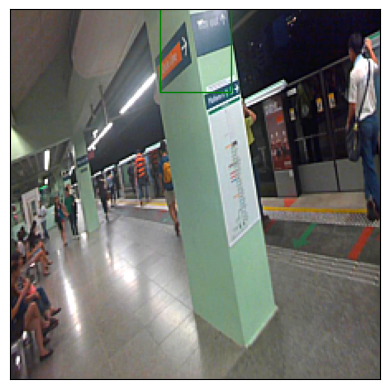

In [42]:
visualize_inference(model, train_dataset)

## References

- [\[1\]](https://arxiv.org/abs/1804.02767) YOLOv3 - Farhadi, A., & Redmon, J. (2018, June). Yolov3: An incremental improvement. In Computer vision and pattern recognition (Vol. 1804, pp. 1-6). Berlin/Heidelberg, Germany: Springer.
- [\[2\]](https://www.kaggle.com/datasets/bestofbests9/icdar2015) ICDAR 2015 - Kaggle.com
- [\[3\]](https://link.springer.com/content/pdf/10.1007/s11036-020-01650-z.pdf) Mobile App Use Cases - Sarker, I. H., Hoque, M. M., Uddin, M. K., & Alsanoosy, T. (2021). Mobile data science and intelligent apps: concepts, AI-based modeling and research directions. Mobile Networks and Applications, 26(1), 285-303.
- [\[4\]](https://arxiv.org/abs/1506.01497) R-CNN - Ren, S., He, K., Girshick, R., & Sun, J. (2016). Faster R-CNN: Towards real-time object detection with region proposal networks. IEEE transactions on pattern analysis and machine intelligence, 39(6), 1137-1149.
- [\[5\]](http://vision.stanford.edu/teaching/cs231b_spring1213/papers/CVPR05_DalalTriggs.pdf) Sliding Window Detectors - Dalal, N., & Triggs, B. (2005, June). Histograms of oriented gradients for human detection. In 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR'05) (Vol. 1, pp. 886-893). Ieee.
- [\[6\]](https://arxiv.org/abs/1911.08287) CIoU - Zheng, Z., Wang, P., Liu, W., Li, J., Ye, R., & Ren, D. (2020, April). Distance-IoU loss: Faster and better learning for bounding box regression. In Proceedings of the AAAI conference on artificial intelligence (Vol. 34, No. 07, pp. 12993-13000).
- [\[7\]](https://arxiv.org/abs/1708.02002) Focal Loss - Ross, T. Y., & Dollár, G. K. H. P. (2017, July). Focal loss for dense object detection. In proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2980-2988).
- [\[8\]](https://arxiv.org/abs/2003.02819) Label Smoothing - Lukasik, M., Bhojanapalli, S., Menon, A., & Kumar, S. (2020, November). Does label smoothing mitigate label noise?. In International Conference on Machine Learning (pp. 6448-6458). PMLR.
- [\[9\]](https://arxiv.org/abs/1710.05941) Activation Functions - Ramachandran, P., Zoph, B., & Le, Q. V. (2017). Searching for activation functions. arXiv preprint arXiv:1710.05941.
- [\[10\]](https://arxiv.org/abs/1905.02244) MobileNetV3 - Howard, A., Sandler, M., Chu, G., Chen, L. C., Chen, B., Tan, M., ... & Adam, H. (2019). Searching for mobilenetv3. In Proceedings of the IEEE/CVF international conference on computer vision (pp. 1314-1324).
- [\[11\]](https://openaccess.thecvf.com/content_CVPR_2020/papers/Wang_ECA-Net_Efficient_Channel_Attention_for_Deep_Convolutional_Neural_Networks_CVPR_2020_paper.pdf) ECA - Wang, Q., Wu, B., Zhu, P., Li, P., Zuo, W., & Hu, Q. (2020). ECA-Net: Efficient channel attention for deep convolutional neural networks. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 11534-11542).
- [\[12\]](https://arxiv.org/abs/1610.02357) DConv - Chollet, F. (2017). Xception: Deep learning with depthwise separable convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1251-1258).
- [\[13\]](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) Dropout - Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.
- [\[14\]](https://openreview.net/forum?id=r1Ddp1-Rb) Zhang, H. (2017). mixup: Beyond empirical risk minimization. arXiv preprint arXiv:1710.09412.
- [\[15\]](https://arxiv.org/abs/1708.07120) OneCycleLR - Smith, L. N., & Topin, N. (2019, May). Super-convergence: Very fast training of neural networks using large learning rates. In Artificial intelligence and machine learning for multi-domain operations applications (Vol. 11006, pp. 369-386). SPIE.
- [\[16\]](https://arxiv.org/abs/1907.08610) Lookahead - Zhang, M., Lucas, J., Ba, J., & Hinton, G. E. (2019). Lookahead optimizer: k steps forward, 1 step back. Advances in neural information processing systems, 32.
- [\[17\]](https://arxiv.org/abs/2011.00241) Pruning - Vadera, S., & Ameen, S. (2022). Methods for pruning deep neural networks. IEEE Access, 10, 63280-63300.
- [\[18\]](https://arxiv.org/abs/1510.00149) Quantization - Han, S., Mao, H., & Dally, W. J. (2015). Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding. arXiv preprint arXiv:1510.00149.